In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
import os
from pathlib import Path

In [9]:
def predict_frames(model: tf.keras.Model, frames: list) -> np.ndarray:
    """
    Predict the class for each frame.
    
    Parameters:
    - model (tf.Model): Trained TensorFlow model.
    - frames (list): List of frames which are preprocessed from the preprocess_frames() function.
    - input_size (tuple): Tuple indicating the input size (height, width) expected by the model.
    
    Returns:
    - predictions (np.ndarray): Array of predictions (0s and 1s).
    """
    pred_probs = model.predict(np.array(frames))
    return pred_probs.flatten()

def preprocess_frames(frames, input_size = (224, 224), to_rgb=True, normalize=False, flip_vertical=False):
    """
    Preprocess a list of frames.

    Args:
        frames (list of numpy arrays): List of frames to be preprocessed.
        input_size (tuple): A tuple specifying the target size for each frame (width, height).
        to_rgb (bool): Whether to convert from BGR to RGB (needed if extracting frames with OpenCV).
        normalize (bool): Whether to normalize (False for EfficientNet models, True otherwise).
        flip_vertical (bool): Whether to flip the image vertically.

    Returns:
        list of numpy arrays: List of preprocessed frames with the following transformations applied:
            1. Resized to the specified input size.
            2. (Optional) Converted from BGR to RGB color format.
            3. (Optional) Normalized.
            4. (Optional) Flipped vertically.
    """
    preprocessed_frames = []

    for frame in tqdm(frames, desc="Processing Frames"):
        # Resize the frame to the specified input size
        frame = cv2.resize(frame, input_size)

        # Convert the frame from BGR to RGB color format if needed
        if to_rgb:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Normalize pixel values to between 0 and 1 if needed
        if normalize:
            frame = frame / 255.0

        # Flip the image vertically if needed
        if flip_vertical:
            frame = cv2.flip(frame, 0)

        preprocessed_frames.append(frame)

    return preprocessed_frames

def load_video_to_frames(video_path: str, start: int = 0, end: int = None) -> list[np.ndarray]:
    """
    Load a video and convert it into a list of frames.
    
    Parameters:
    - video_path (str): Path to the video file.
    
    Returns:
    - frames (list[np.ndarray]): List of frames.
    """
    if end is None:
        end = np.inf
    
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # for progress bar
    frames = []
    
    i = 0
    with tqdm(total=total_frames, desc="Converting to Frames") as progress_bar_tqdm:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            if start <= i <= end:
                frames.append(frame)
            progress_bar_tqdm.update(1)  # Update the tqdm progress bar
            i += 1
    
    cap.release()
    return frames


In [10]:
model_big_dir = Path(os.getcwd()).parent / "models" / "sr_sv_nr_v2-l-4e-1f.h5"
model_big = tf.keras.models.load_model(model_big_dir)
print("Loaded big model: input shape = (480, 480)")
model_small_dir = Path(os.getcwd()).parent / "models" / "b0_2_epochs_half_data_h5.h5"
model_small = tf.keras.models.load_model(model_small_dir)
print("Loaded small model: input shape = (224, 224)")

Loaded big model: input shape = (480, 480)
Loaded small model: input shape = (224, 224)


In [11]:
small_frames = preprocess_frames(load_video_to_frames(str(Path(os.getcwd()).parent /"media"/ "whole_thing_cropped.mp4"), start=13200), (224, 224))

Processing Frames: 100%|██████████| 1137/1137 [00:00<00:00, 6905.86it/s]


In [12]:
predictions_small_13200 = predict_frames(model_small, small_frames)

2024-01-24 09:54:10.800816: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


36/36 [==============================] - 2s 18ms/step


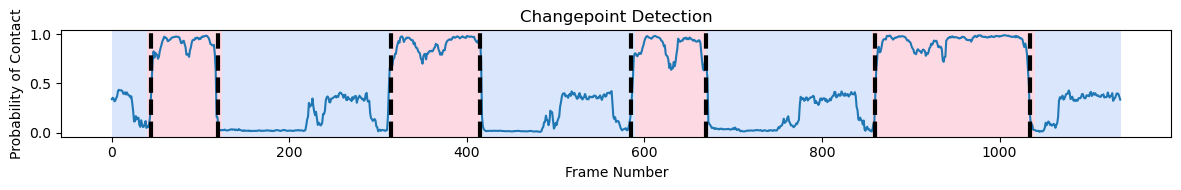

In [13]:
import ruptures as rpt

algo = rpt.Pelt(model="l2", min_size=15).fit(predictions_small_13200)
small_bkps = algo.predict(pen=10)

true_bkps = [40, 125, 315, 415, 590, 670, 857, 1040, len(predictions_small_13200)] # eyeballing it
# Plot the results in the corresponding subplot
fig_current, ax_current = rpt.show.display(predictions_small_13200, true_bkps, small_bkps, figsize=(12, 2))
plt.title(f"Changepoint Detection")
plt.ylabel("Probability of Contact")
plt.xlabel("Frame Number")
plt.tight_layout()
# plt.savefig("PELT_demo.png", dpi=300)
plt.show()

In [14]:
big_frames = preprocess_frames(load_video_to_frames(str(Path(os.getcwd()).parent / "media"/ "whole_thing_cropped.mp4"), start=13200), (480, 480))

Processing Frames: 100%|██████████| 1137/1137 [00:00<00:00, 6170.87it/s]


In [15]:
big_frames_13200 =  big_frames

In [16]:
predictions_big_13200 = predict_frames(model_big, big_frames_13200)

36/36 [==============================] - 23s 472ms/step


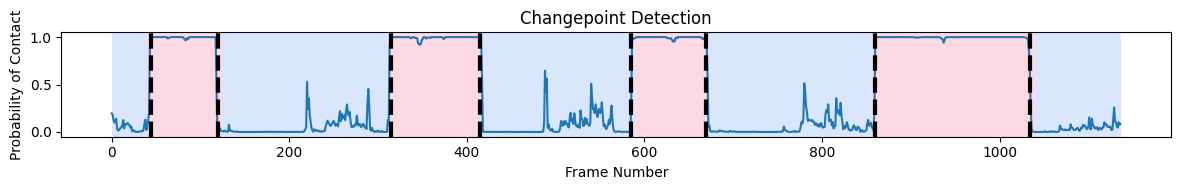

In [ ]:
algo = rpt.Pelt(model="l2", min_size=15).fit(1 - predictions_big_13200)
big_bkps = algo.predict(pen=10)

true_bkps = [40, 125, 315, 415, 590, 670, 857, 1040, len(predictions_big_13200)] # eyeballing it
# Plot the results in the corresponding subplot
fig_current, ax_current = rpt.show.display(1 - predictions_big_13200, true_bkps, big_bkps, figsize=(12, 2))
plt.title(f"Changepoint Detection")
plt.ylabel("Probability of Contact")
plt.xlabel("Frame Number")
plt.tight_layout()
# plt.savefig("PELT_demo.png", dpi=300)
plt.show()

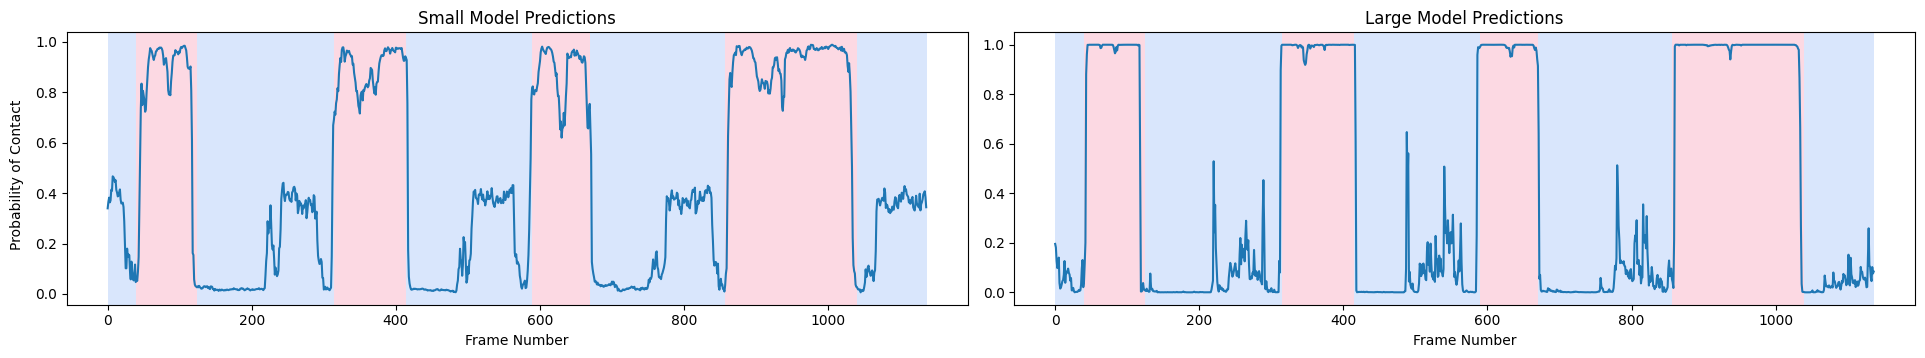

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle

def plot_dual_signals(signal1, signal2, computed_chg_pts1, computed_chg_pts2, true_bkps=None, suptitle=None, x_label=None, y_label=None, title1=None, title2=None, **kwargs):
    """
    Plots two line charts next to each other, each with their own computed change points.
    If true_bkps is provided, it alternates shaded regions in both plots.

    Args:
        signal1 (array-like): First signal array.
        signal2 (array-like): Second signal array.
        computed_chg_pts1 (list): Computed change points for the first signal.
        computed_chg_pts2 (list): Computed change points for the second signal.
        true_bkps (list, optional): True breakpoints to be displayed on both plots.
        suptitle (str, optional): Super-title for the entire figure.
        x_label (str, optional): Label for the x-axis (applied to both plots).
        y_label (str, optional): Shared label for the y-axis.
        title1 (str, optional): Title of left plot.
        title2 (str, optional): Title of right plot.
        **kwargs: Additional keyword arguments for plt.subplots.
    """

    # Convert signals to numpy arrays if they aren't already
    signal1 = np.asarray(signal1)
    signal2 = np.asarray(signal2)

    # Ensure signals are 2D arrays
    if signal1.ndim == 1:
        signal1 = signal1.reshape(-1, 1)
    if signal2.ndim == 1:
        signal2 = signal2.reshape(-1, 1)

    # Check if signals have the same length
    if signal1.shape[0] != signal2.shape[0]:
        raise ValueError("Both signals must have the same length.")

    n_samples = signal1.shape[0]

    # Default plot settings
    matplotlib_options = {
        "figsize": (20, 6),  # wider figure size to accommodate two plots
    }
    matplotlib_options.update(kwargs)

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, **matplotlib_options)

    # Function to plot each signal
    def plot_signal(ax, signal, computed_chg_pts):
        ax.plot(range(n_samples), signal)
        if computed_chg_pts is not None:
            for bkp in computed_chg_pts:
                if bkp != 0 and bkp < n_samples:
                    ax.axvline(x=bkp - 0.5, color='k', linestyle='--', linewidth=3)

        # Alternate shaded regions
        if true_bkps is not None:
            bkps = [0] + true_bkps + [n_samples]
            colors = cycle(["#4286f4", "#f44174"])
            for start, end, col in zip(bkps, bkps[1:], colors):
                ax.axvspan(max(0, start - 0.5), end - 0.5, facecolor=col, alpha=0.2)

    # Plot each signal
    plot_signal(ax1, signal1, computed_chg_pts1)
    plot_signal(ax2, signal2, computed_chg_pts2)

    # Set the titles and labels
    if suptitle:
        fig.suptitle(suptitle)
    if title1:
        ax1.title.set_text(title1)
    if title2:
        ax2.title.set_text(title2)
    if x_label:
        ax1.set_xlabel(x_label)
        ax2.set_xlabel(x_label)
    if y_label:
        fig.text(0.04, 0.5, y_label, va='center', rotation='vertical')

    fig.tight_layout(rect=[0.045, 0.03, 1, 0.95])  # Adjust layout to make room for figure title and y-label
    return fig, (ax1, ax2)

plot_dual_signals(predictions_small_13200, 1 - predictions_big_13200, [], [], true_bkps, figsize = (20, 4), x_label="Frame Number", y_label="Probability of Contact", title1="Small Model Predictions", title2="Large Model Predictions")
plt.show()

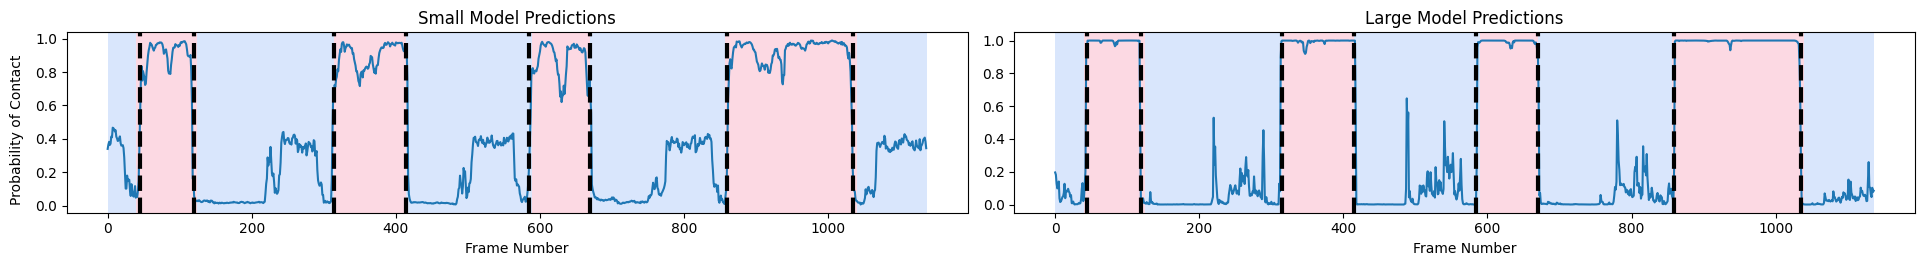

In [ ]:
plot_dual_signals(predictions_small_13200, 1 - predictions_big_13200, small_bkps, big_bkps, true_bkps, figsize = (20, 3), x_label="Frame Number", y_label="Probability of Contact", title1="Small Model Predictions", title2="Large Model Predictions")
plt.show()

In [ ]:
predictions_small = predict_frames(model_small, small_frames)

In [ ]:
import ruptures as rpt

algo = rpt.Pelt(model="l2", min_size=15).fit(predictions_small)
small_bkps = algo.predict(pen=10)

true_bkps = [40, 125, 315, 415, 590, 670, 857, 1040, len(predictions_small_13200)] # eyeballing it
# Plot the results in the corresponding subplot
fig_current, ax_current = rpt.show.display(predictions_small_13200, true_bkps, small_bkps, figsize=(12, 2))
plt.title(f"Changepoint Detection")
plt.ylabel("Probability of Contact")
plt.xlabel("Frame Number")
plt.tight_layout()
# plt.savefig("PELT_demo.png", dpi=300)
plt.show()